# AerE 361 Lecture - Randomness and Rockets
## Prof. Nelson


![alt text](https://www.explainxkcd.com/wiki/images/7/77/ensemble_model.png)

## Monte Carlo...again

A Monte Carlo method is a technique that uses random numbers and probability to solve complex problems. The Monte Carlo simulation, or probability simulation, is a technique used to understand the impact of risk and uncertainty in financial sectors, project management, costs, and other forecasting machine learning models.

Risk analysis is part of almost every decision we make, as we constantly face uncertainty, ambiguity, and variability in our lives. Moreover, even though we have unprecedented access to information, we cannot accurately predict the future.

The Monte Carlo simulation allows us to see all the possible outcomes of our decisions and assess risk impact, in consequence allowing better decision making under uncertainty.

# RocketSim
There are many tools you can use with Python and one such tool we can use is a toolbox called [RocketPy](https://github.com/RocketPy-Team/RocketPy). This tool allows us to load in different rocket motors, parachutes and other configurations. If you are interested in rocket simulation, I encourage you to check them out. For now, we will look at setting up a rocket and use a Monte Carlo simulation on the rocket setup.

We start by setting up our environment. To run this notebook, we will need:

- RocketPy
- Data files (we will download RocketPy's data from github)

RocketPy has already been installed in the HPC. I have also included the data files you will need for this ICA. 

Please also note, you will probably want to create additional code or markdown blocks to this notebook as needed.

In [1]:
# Don't forget to run this block
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from time import process_time, perf_counter, time
import glob

from rocketpy import Environment, SolidMotor, Rocket, Flight, MonteCarlo


import numpy as np
from numpy.random import normal, uniform, choice
from IPython.display import display
import matplotlib as mpl
from matplotlib.patches import Ellipse
import imageio

## Setting Up a Simulation - Spaceport America
The `Environment` class is used to define the atmosphere, the winds, and the gravity models.

You can find more information about the `Environment` class in the [Environment Class Usage Docs](https://docs.rocketpy.org/en/latest/notebooks/environment/environment_class_usage.html).

In [2]:
env = Environment(latitude=32.990254, longitude=-106.974998, elevation=1400)

To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.

In [3]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
)  # Hour given in UTC time

Then, we tell env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.


In [4]:
env.set_atmospheric_model(type="Forecast", file="GFS")

We can see what the weather will look like by calling the info method!



Gravity Details

Acceleration of gravity at surface level:    9.7911 m/s²
Acceleration of gravity at  79.158 km (ASL): 9.5559 m/s²


Launch Site Details

Launch Date: 2024-12-04 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.5 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 79.158 km
Forecast Time Period: from 2024-12-03 06:00:00 to 2024-12-19 06:00:00 utc
Forecast Hour Interval: 3 hrs
Forecast Latitude Range: From -90.0° to 90.0°
Forecast Longitude Range: From 0.0° to 359.75°

Surface Atmospheric Conditions

Surface Wind Speed: 0.90 m/s
Surface Wind Direction: 40.46°
Surface Wind Heading: 220.46°
Surface Pressure: 856.28 hPa
Surface Temperature: 283.42 K
Surface Air Density: 1.052 kg/m³
Surface Speed of Sound: 337.49 m/s


Earth Model Details

Earth Radius at Launch 

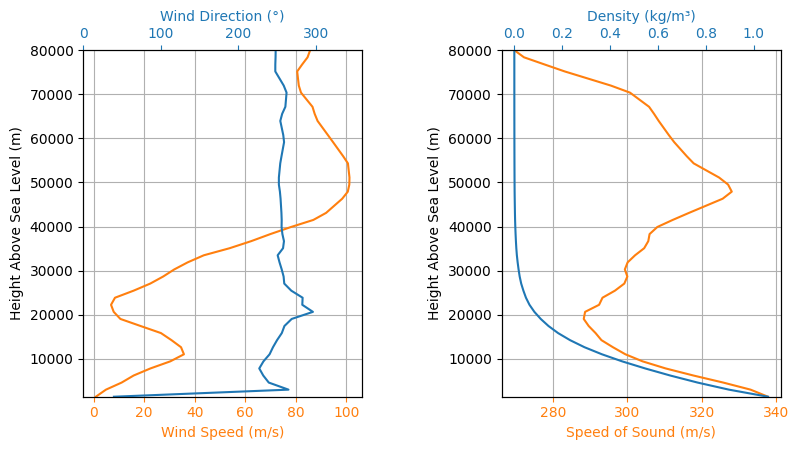

In [5]:
env.info()

# Rocket Sim
With that set, we will now setup the rocket. I have set this up for you, so just run the code blocks below.

## Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

See [Solid Motor Class Usage Docs](https://docs.rocketpy.org/en/latest/user/motors/solidmotor.html) for more information.


In [6]:
Pro75M1670 = SolidMotor(
    thrust_source="Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

## Creating a rocket

A rocket is composed of several components. Namely, we must have a motor (good thing we have the Pro75M1670 ready), a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

You can find more information about the `Rocket` class in the [Rocket Class Usage Docs](https://docs.rocketpy.org/en/latest/user/rocket.html).

Let's start by initializing our rocket, named Calisto, entering inertia properties, some dimensions and drag curves.

**Pay special attention to *position* related parameters:**
More details on [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)



In [7]:
calisto = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="powerOffDragCurve.csv",
    power_on_drag="powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = calisto.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

To add the motor to our rocket we need only inform what motor we are adding (Pro75M1670) and inform the position, in meters, of the motor's nozzle exit area relative to the previously defined coordinate system.


In [8]:
calisto.add_motor(Pro75M1670, position=-1.255)

## Adding Aerodynamic Surfaces

Now we define the aerodynamic surfaces. They are really straight forward with special attention needed only for the position values. Here is a quick guide:

- The positions given **must** be relative to the same coordinate system as the rockets;
- Position of the Nosecone refers to the tip of the nose;
- Position of fins refers to the point belonging to the root chord which is highest in the rocket coordinate system;
- Position of the tail the point belonging to the tail which is highest in the rocket coordinate system.

See more details in [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)

In [9]:
nose_cone = calisto.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("NACA0012-radians.txt", "radians"),
)

tail = calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

And now you should look at your rocket details.


Inertia Details

Rocket Mass: 14.426 kg (without motor)
Rocket Dry Mass: 16.241 kg (with unloaded motor)
Rocket Loaded Mass: 19.197 kg
Rocket Structural Mass Ratio: 0.846
Rocket Inertia (with unloaded motor) 11: 7.864 kg*m2
Rocket Inertia (with unloaded motor) 22: 7.864 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.036 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0635 m
Rocket Frontal Area: 0.012668 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.105 m
Rocket Center of Dry Mass - Nozzle Exit: 1.150 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.753 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.116 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 6.280/rad
Tail Lift Coefficient De

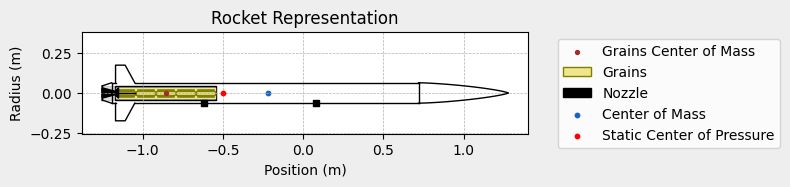


Mass Plots
----------------------------------------


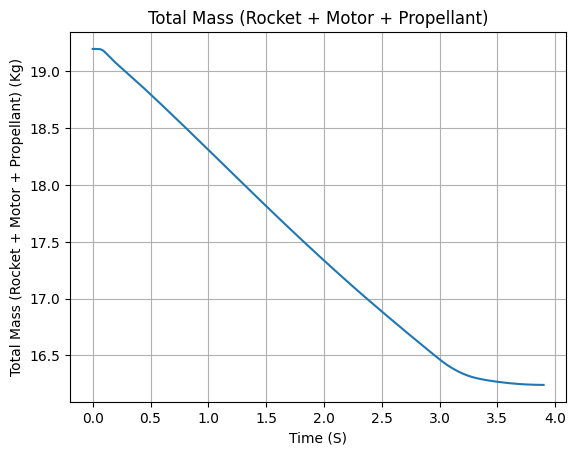

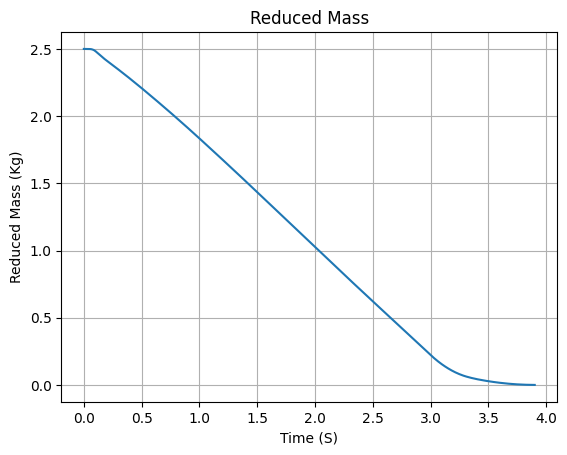


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


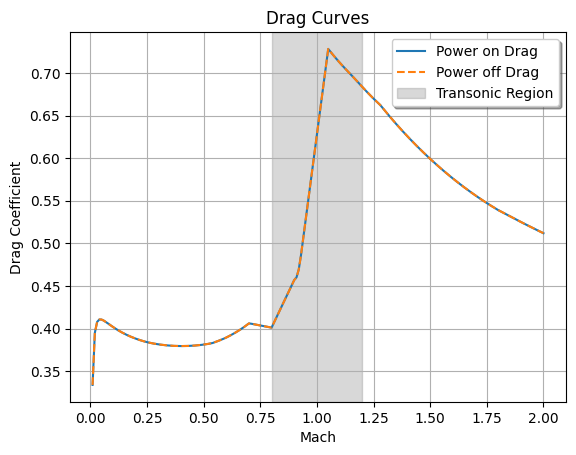


Stability Plots
--------------------


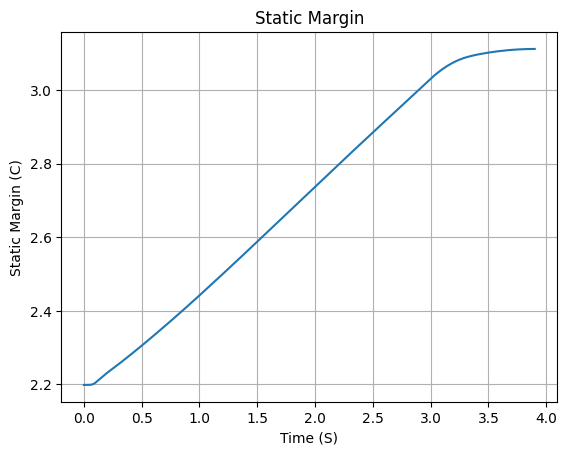

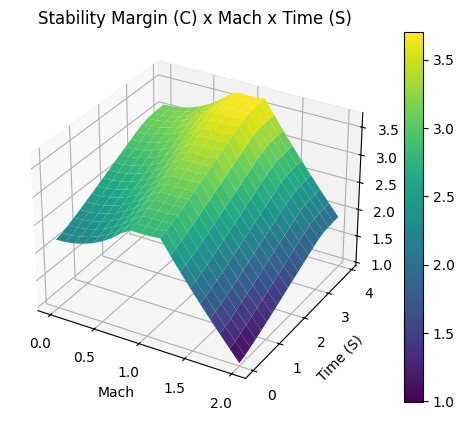


Thrust-to-Weight Plot
----------------------------------------


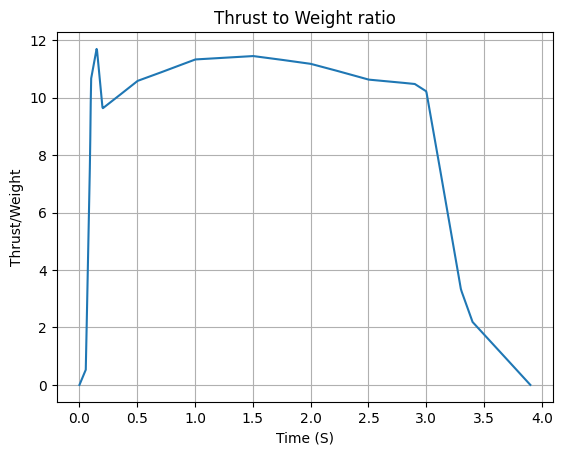

In [10]:
calisto.all_info()

## Adding the parachute
Finally, we have parachutes! Calisto will have two parachutes, Drogue and Main. The Drogue parachute will open at apogee while the Main parachute will open at 800m above ground level

For more details see [Adding Parachutes](https://docs.rocketpy.org/en/latest/user/rocket.html#adding-parachutes)

In [11]:
Main = calisto.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = calisto.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

## Running a simulation.

Now you need to read the documentation and run the simulation. Your rail length will be 5.2 and your inclination will be 85 degrees. Once done, Analyze the results and provide a summary in this notebook. Export a KML file of the trajectory of the path. Call it "trajectory.kml". Set the extrusion for this to True and put the altitude mode to Relative to ground. 

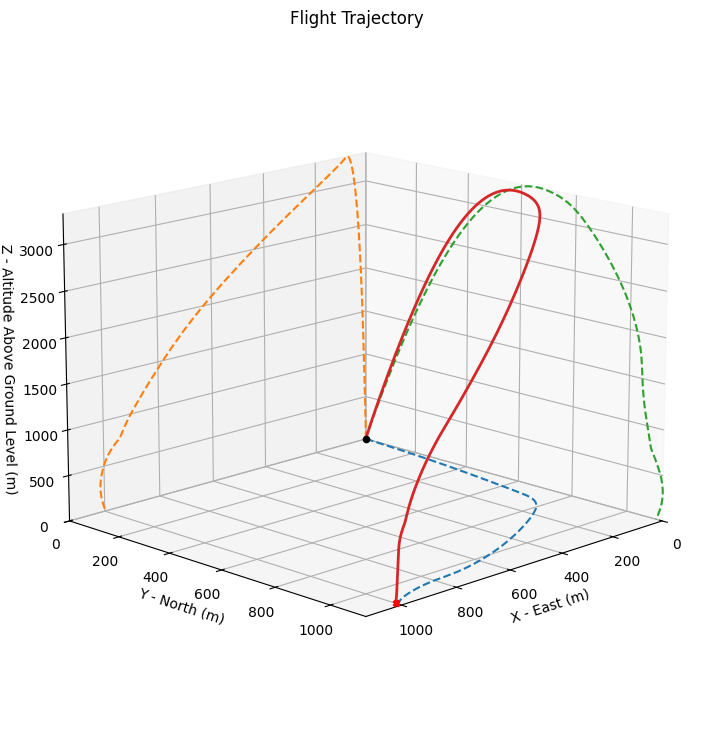

File  trajectory.kml  saved with success!


In [15]:
test_flight = Flight(
    rocket=calisto, environment=env, rail_length=5.2, inclination=85, heading=0
    )
test_flight.plots.trajectory_3d()
test_flight.export_kml(
    file_name="trajectory.kml",
    extrude=True,
    altitude_mode="relative_to_ground",
)

## Using Simulation for Design
Your next task is to determine what the maximum payload mass is, without motor, that will result in the rocket achieving 4 km at apogee. Include a graph of the simulation and your answer.

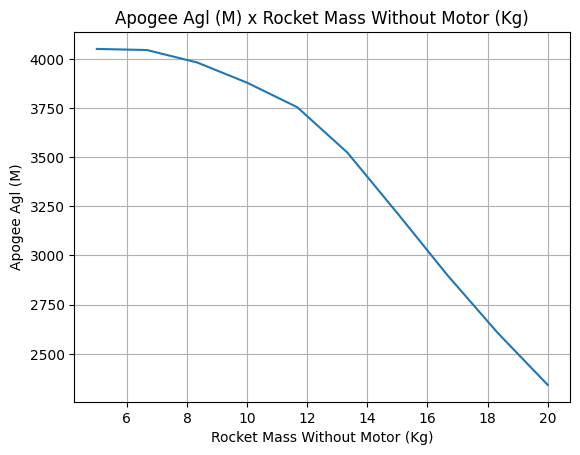

Max payload to reach 4km is 7.972058741719718 kgs


In [23]:
from rocketpy.utilities import apogee_by_mass
from scipy.optimize import fsolve

f = apogee_by_mass(flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True)
maxpayload = fsolve(f-4000,10)
print(f"Max payload to reach 4km is {maxpayload[0]} kgs")

## Monte Carlo Simulation (Extra Credit)
Perform a Monte Carlo Simulation of at least 100 simulations for this rocket. Output a KML file that shows the simulation of where Apogee is and the landing.

**hint** you will need to change the atmospheric model to Ensemble like below.

```Python
env.set_atmospheric_model(type="Ensemble", file="GEFS")
```